In [1]:
# -*- coding: utf-8 -*-
"""
The script demonstrates a comparison of vehicle times from AVL data to the
scheduled arrival time at one stop for one example trip.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
import sys
sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

In [2]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops3(merged_row):
    distance_stops = merged_row.stop_dist_on_trip
    if len(merged_row.timestamp)<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(merged_row.timestamp,merged_row.veh_dist_along_trip)))
    veh_pings = pd.Series(index=list1,data=list2)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(merged_row.next_stop_id,masker)),interp_times]

In [68]:
# for iteration over dict-of-dicts (each dict is a collection of lists of necessary data)
def interpolate_stops4(d):
    distance_stops = d['stop_dist_on_trip']
    if len(d['timestamp'])<2:
        return [[]]    
    list1, list2 = zip(*sorted(zip(d['timestamp'],d['veh_dist_along_trip'])))
    veh_pings = pd.Series(index=list1,data=list2)
    last = veh_pings.idxmax()
    first = veh_pings.sort_index(ascending=False).idxmin()
    veh_pings = veh_pings.dropna()
    if len(veh_pings) == 0:
        return [[]]
    inter_stops = veh_pings.loc[first:last]
    if len(inter_stops)<2:
        return [[]]
    x = inter_stops.values
    y = inter_stops.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    interp_times = pd.to_timedelta(f(xnew),unit='ns')    
    return [list(compress(d['next_stop_id'],masker)),interp_times]

## Now try it on a WHOLE DAY of data...
#### Potential weakness: only uses the most common shape_id for each trip

In [3]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('spark_parse/1203.txt',header=None)

# beware!  Bonan is still working on organizing the extract files.  these columns may change.
bustime.columns = ['route','lat','lon','timestamp','vehicle_id','trip_id','trip_date','shape_id',
                   'next_stop_id','dist_from_stop','stop_dist_on_trip','presentable_dist']

bustime.drop_duplicates(['vehicle_id','timestamp'],inplace=True)
bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')

bustime.set_index(['route','trip_id','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('timestamp',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data one day.
tripDateLookup = "2015-12-03"
bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)
bustime['timestamp'] = bustime['timestamp'].apply(ttools.parseActualTime,tdate='2015-12-03')

bustime['stop_dist_on_trip'] = bustime['stop_dist_on_trip'].convert_objects(convert_numeric=True)
bustime['dist_from_stop'] = bustime['dist_from_stop'].convert_objects(convert_numeric=True)
bustime['veh_dist_along_trip'] = bustime['stop_dist_on_trip'] - bustime['dist_from_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [4]:
bustime_distances = bustime.drop(['timestamp'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['route','trip_id','trip_date','vehicle_id','timestamp',
                                                'lat','lon','dist_from_stop','presentable_dist',
                                                'veh_dist_along_trip'],axis=1,inplace=False)

stop_distances = bustime_distances.drop_duplicates(['shape_id','next_stop_id','stop_dist_on_trip'])
stop_distances = stop_distances.query('stop_dist_on_trip > 0.1')
stop_distances.shape_id = stop_distances.shape_id.str.replace('MTA_','')
stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['shape_id','stop_dist_on_trip']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


In [5]:
avl_data2 = bustime
avl_data2.shape_id = avl_data2.shape_id.str.replace('MTA_','')
avl_data2.next_stop_id = avl_data2.next_stop_id.str.replace('MTA_','')

In [6]:
gb = avl_data2.groupby(level=(0,1,2,3))

In [7]:
reported_timestamps = gb['timestamp'].apply(list)
reported_dists = gb['veh_dist_along_trip'].apply(list)
shape_ids = gb['shape_id'].agg(lambda x:x.value_counts().index[0])

In [8]:
all_dists = stop_distances.groupby('shape_id')['stop_dist_on_trip'].apply(list)
all_stops = stop_distances.groupby('shape_id')['next_stop_id'].apply(list)
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='shape_id',right_index=True).merge(pd.DataFrame(all_stops),left_on='shape_id',right_index=True)

Approach 1: merge everything into a dataframe

In [72]:
starttime = time.time()
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
print 'Processing time:'
print time.time() - starttime

Processing time:
0.457190990448


Approach 2: merge everything as a dict-of-dicts

In [73]:
starttime = time.time()
test_dict = {}
for i,v in all_stop_dists.iterrows():
    test_dict[i] = {'stop_dist_on_trip':v.stop_dist_on_trip,'next_stop_id':v.next_stop_id,
                    'timestamp':reported_timestamps.loc[i],'veh_dist_along_trip':reported_dists.loc[i]}
print 'Processing time:'
print time.time() - starttime

Processing time:
17.3464970589


### Compare performance when iterating over dataframe of lists or dict of dicts
Approach 1

In [70]:
starttime = time.time()
results = {}
for i, v in avl_merged.iterrows():
    results[i] = interpolate_stops3(v)
print 'Processing time:'
print time.time() - starttime

1468182200.67
1468182289.64


Approach 2

In [71]:
starttime = time.time()
results2 = {}
for k, v in test_dict.iteritems():
    results2[k] = interpolate_stops4(v)
print 'Processing time:'
print time.time() - starttime

1468182368.52
1468182445.93


## Investigate results

In [74]:
lens = []
trip_count = 0
for k, v in results.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)

In [76]:
print 'Some basic stats: '
print 'Total number of estimated arrival times'
print sum(lens)
print 'Number of trips identified overall'
print len(lens)
print 'Number of trips with estimates'
print trip_count
print 'Average number of estimates per trip'
print 1.0*sum(lens)/trip_count

Some basic stats: 
Total number of estimated arrival times
1546160
Number of trips identified overall
66086
Number of trips with estimates
48825
Average number of estimates per trip
31.6673835125


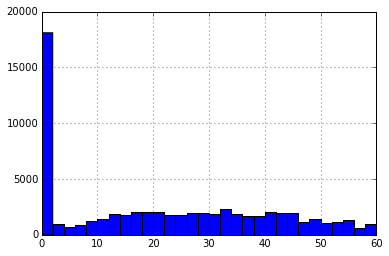

In [77]:
pd.Series(lens).hist(range=(0,60),bins=30)

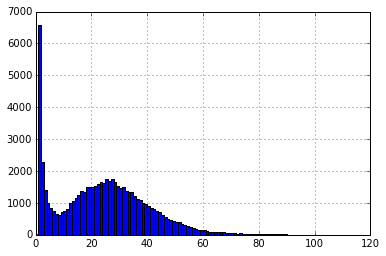

In [78]:
gb.size().hist(range=(0,120),bins=120)